In [1]:
%load_ext watermark
%watermark --python --datename --machine

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 4.15.0-151-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [2]:
%matplotlib inline
import math
import os

import cv2
import isupgrader.data.tiler.v4
import matplotlib.pyplot as plt
import pandas as pd
import tifffile
from tqdm.notebook import tqdm

%watermark --iversion

matplotlib: 3.4.2
pandas    : 1.1.4
tifffile  : 2021.7.30
cv2       : 4.5.3



In [3]:
IMG_ID = "000920ad0b612851f8e01bcc880d9b3d"

# Tiling
TILE_SIZE=256
N_TILES=16
LEVEL=1

In [4]:
TRAIN_IMAGES = "/data/raw/panda/train_images/"
df = pd.read_csv("/data/raw/panda/train.csv")

# Change negative gleason_score to 0+0
df["gleason_score"] = df["gleason_score"].apply(lambda x: "0+0" if x=="negative" else x)

In [5]:
def plot_tiles(tiles):
    grid_size = math.ceil(len(tiles)**0.5)

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(16,16))
    axs = axs.flatten()

    for ax in axs:
        ax.axis("off")
        
    for tile, ax in zip(tiles, axs):
        ax.axis("on")
        ax.tick_params(which="both",bottom=False,left=False,labelbottom=False,labelleft=False)
        ax.imshow(tile, aspect="auto")

    fig.subplots_adjust(hspace=0, wspace=0)
    
    plt.show()

In [6]:
%%time

tiff_file = os.path.join(TRAIN_IMAGES, f'{IMG_ID}.tiff')
image = tifffile.imread(tiff_file, key=LEVEL)
tiles, coords = isupgrader.data.tiler.v4.generate_tiles(image, TILE_SIZE, only_tiles=False)

print(f"Number of tiles: {len(coords)}")

Number of tiles: 11
CPU times: user 902 ms, sys: 333 ms, total: 1.24 s
Wall time: 913 ms


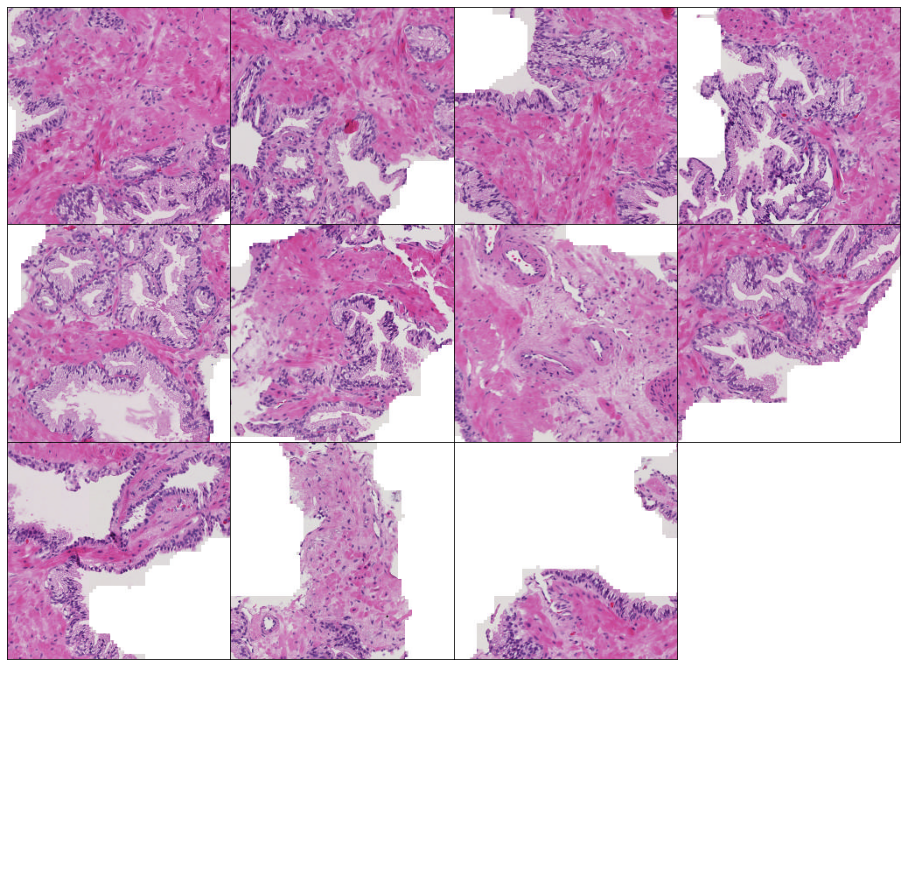

In [7]:
plot_tiles(tiles)

In [8]:
def visualise_tiles(image, tiles, coords, resize_factor=0.33):
    tile_size = int(tiles.shape[1] * resize_factor)
    new_shape = (int(image.shape[1] * resize_factor), int(image.shape[0] * resize_factor))

    # resize image and darken image
    image = cv2.resize(image, new_shape, interpolation=cv2.INTER_LANCZOS4) // 3

    for i, (_, y, x) in enumerate(coords):
        x, y = int(x * resize_factor), int(y * resize_factor)
        image[y: y + tile_size, x: x + tile_size] = cv2.resize(tiles[i],
                                                               (tile_size, tile_size),
                                                               interpolation=cv2.INTER_LANCZOS4)

    for i, (_, y, x) in enumerate(coords):
        x, y = int(x * resize_factor), int(y * resize_factor)

        start_point = (x, y)
        end_point = (x + tile_size, y + tile_size)

        colour = (0, 0, 0)

        image = cv2.rectangle(image, start_point, end_point, colour, 4)

    return image


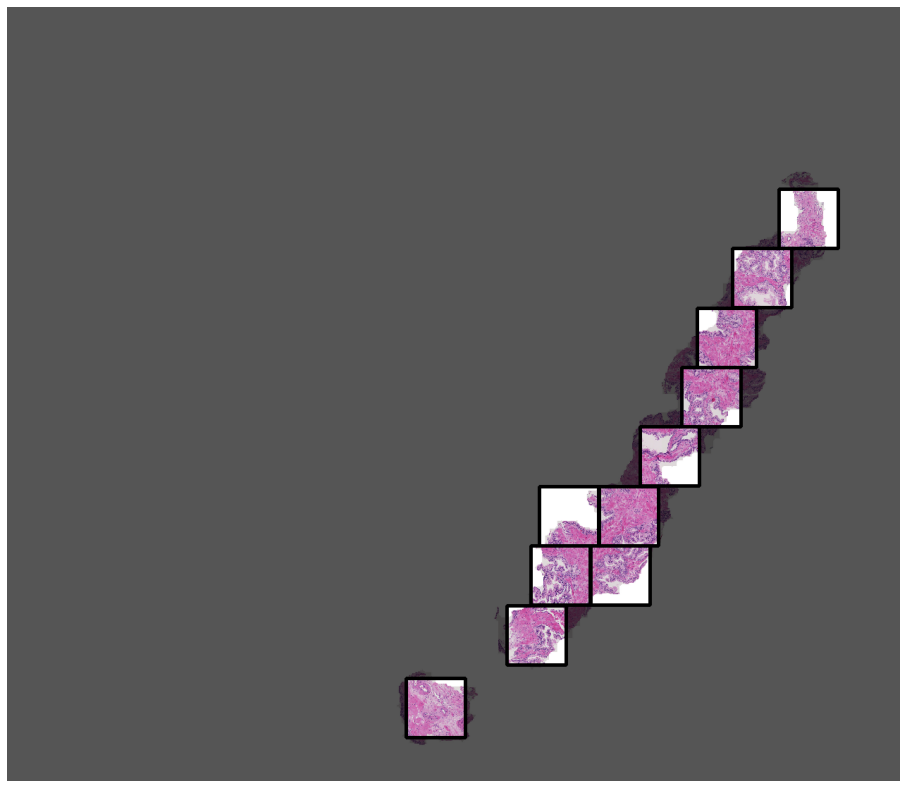

In [9]:
plt.figure(figsize=(16,16))
plt.imshow(visualise_tiles(image, tiles, coords))

del image, tiles, coords

plt.axis('off')
plt.show()

0it [00:00, ?it/s]

ValueError: could not broadcast input array from shape (84,84,3) into shape (84,0,3)

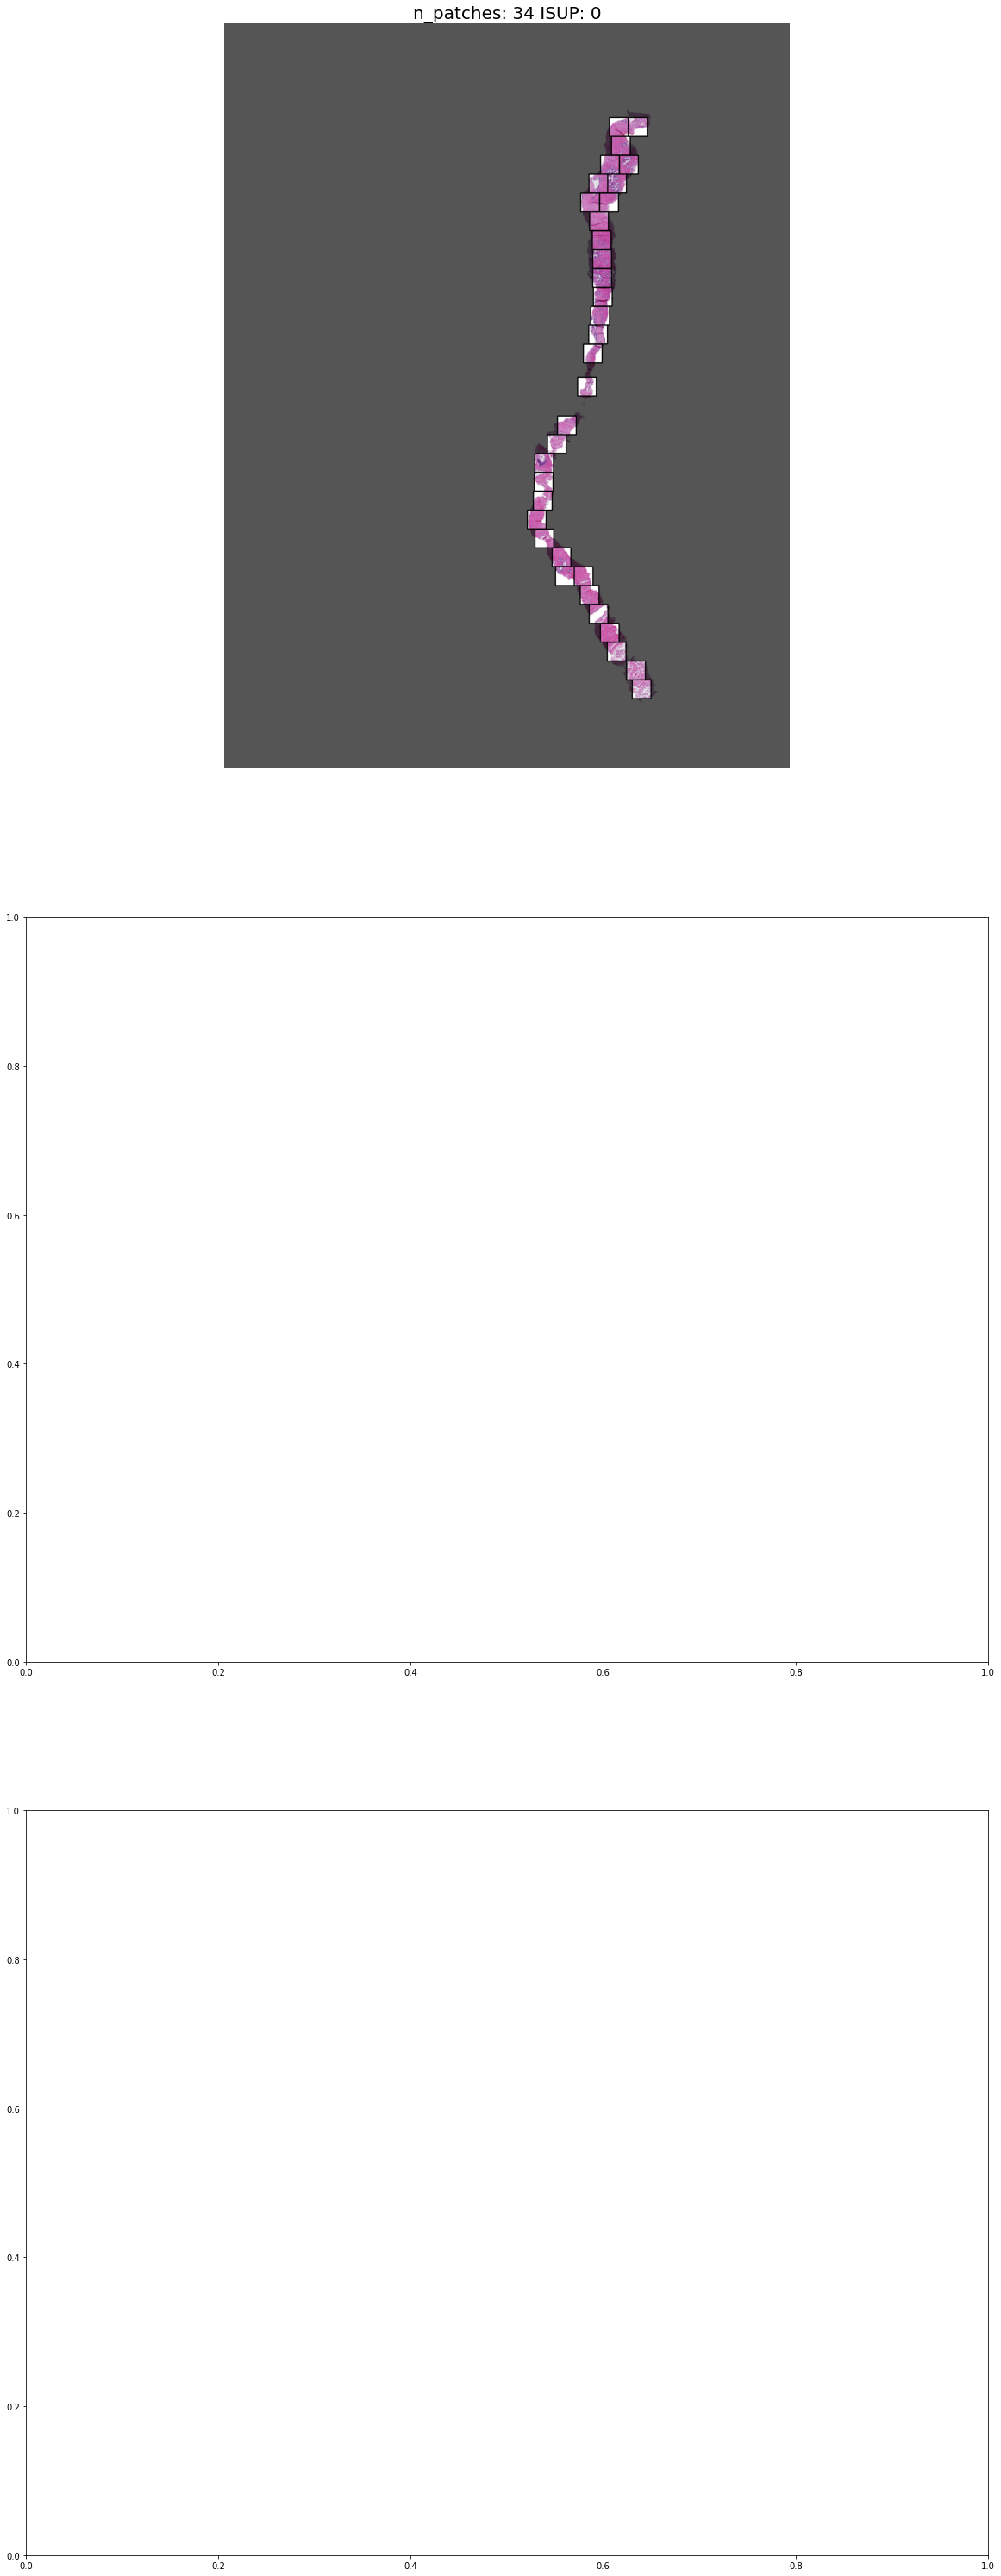

In [10]:
n_slides = 3
sample_slides = df.sample(n_slides).to_numpy()

fig, axs = plt.subplots(n_slides, 1, figsize=(20, 18*n_slides))

for slide, ax in tqdm(zip(sample_slides, axs)):
    image_id = slide[0]
    isup = slide[2]

    tiff_file = os.path.join(TRAIN_IMAGES, f'{image_id}.tiff')
    image = tifffile.imread(tiff_file, key=LEVEL)
    tiles, coords = isupgrader.data.tiler.v4.generate_tiles(image, TILE_SIZE, only_tiles=False)

    ax.imshow(visualise_tiles(image, tiles, coords))
    ax.axis('off')
    ax.set_title(f"n_patches: {len(coords)} ISUP: {isup}", fontsize=20)
